 **Worm Simulation on 2D Ising Lattice**
===================

# Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from utils import *
from worm_simulation import WormSimulation
from bonds import Bonds
from iterated_blocking import *
from specific_heat import SpecificHeat
from pca import PrincipalComponent
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
#from matplotlib.offsetbox import AnchoredText
#import matplotlib.offsetbox as offsetbox
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.signal import find_peaks_cwt
#import mpltex
colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#EE2324']
markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',  '#Db1f0e']
#colors = ['#5A9BD4', '#Faa75b', '#7AC36A', '#9D67Ab', '#F15A5F', '#737373',
#         '#D77FB4', '#CE7059']
#markeredgecolors = ['#185AA9', '#F47D23', '#008c48', '#662c91', '#Ef2E30',
#                    '#010202', '#B43894', '#A21E20']

%autoreload 2
%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))    # critical temperature

In [13]:
def get_plot_num(out_dir):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    existing = [
        int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
        if i.endswith('.png')
    ]
    try:
        latest_num = int(max(existing))
    except ValueError:
        latest_num = 0
    return latest_num + 1

In [14]:
def FWHM(X,Y):
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = (np.sign(half_max - np.array(Y[0:-1])) 
         - np.sign(half_max - np.array(Y[1:])))
    #plot(X,d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    
    #left_idx = (d > 0)[0]
    #right_idx = np.find(d < 0)[-1]
    return X[right_idx] - X[left_idx] #return the difference (full width)

In [15]:
markers = ['s', 'H', 'd', 'v', 'p']
#colors = ['C0', 'C1', '#65e41d', '#be67ff', '#EE2324']
#colors = ['C0', 'C1', 'C2', 'C4', 'C3']
#markeredgecolors = ['#1f1b93', '#ed4c18',  '#00B000',  '#6633cc',  '#Db1f0e']
#markeredgecolors = ['#236cb7', '#df6a0b',  '#32637A', '#6633cc',  '#Db1f0e']
colors = ['#1D92cb', 'C1', '#65e41d', '#be67ff', '#EE2324']
markeredgecolors = ['#064877', '#ed4c18',  '#00B000', '#6633cc',  '#Db1f0e']

def make_plots(x_arr, y_arr, y_err,  labels, xlabel, ylabel, 
               out_file, xlimits=None, ylimits=None):
    fig, ax = plt.subplots()
    linestyles = mpltex.linestyle_generator()
    ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
    for i in range(len(x_arr)):
        ax.errorbar(x_arr[i], y_arr[i], yerr=y_err[i],
                    label=labels[i], marker=markers[i], markersize=5,
                    color=colors[i], markeredgecolor=markeredgecolors[i],
                    ls='-', fillstyle='full', lw=2.,
                    elinewidth=2.,  alpha=1.0,
                    capsize=2, capthick=2)
    leg = ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    if xlimits is not None:
        xlim = ax.set_xlim(xlimits[0], xlimits[1])
    if ylimits is not None:
        ylim = ax.set_ylim(ylimits[0], ylimits[1])
    fig.tight_layout()
    print("Saving file to: {}".format(out_file))
    fig.savefig(out_file, dpi=400, bbox_inches='tight')
    return fig, ax

# Data Analysis

## Specific Heat

In [39]:
specific_heat64 = SpecificHeat(64, num_blocks=10)
specific_heat32 = SpecificHeat(32, num_blocks=50)
specific_heat16 = SpecificHeat(16, num_blocks=50)
specific_heat8 = SpecificHeat(8, num_blocks=50)
specific_heat4 = SpecificHeat(4, num_blocks=50)
#7.81s num_blocks=2

## $\langle N_b \rangle$, and $\langle \Delta_{N_b}^2\rangle$

### Load from previously computed data

#### L = 2

In [18]:
#count_bonds2 = CountBonds(2, load=True, d)
save_dir2 = (
    '../data/bond_stats/iterated_blocking/{}_lattice/'.format(2)
)
config_dir4_b2 = '../data/iterated_blocking/4_lattice/blocked_2/'
count_bonds2 = CountBonds(L=2, load=True,
                          data_dir=config_dir4_b2,
                          save_dir=save_dir2)
Nb2 = np.array([
    (i[0], i[1]) for i in list(count_bonds2.bond_stats.values())
])
delta_Nb2 = np.array([
    (i[2], i[3]) for i in list(count_bonds2.bond_stats.values())
])
Nb2_temps = np.array([
    float(i) for i in list(count_bonds2.bond_stats.keys())
])

Reading from: ../data/bond_stats/iterated_blocking/2_lattice/bond_stats_2.txt


#### L = 4

In [19]:
count_bonds4 = CountBonds(4, load=True)
Nb4 = np.array([
    (i[0], i[1]) for i in list(count_bonds4.bond_stats.values())
])
delta_Nb4 = np.array([
    (i[2], i[3]) for i in list(count_bonds4.bond_stats.values())
])
Nb4_temps = np.array([
    float(i) for i in list(count_bonds4.bond_stats.keys())
])
################    BLOCKED    ################
count_bonds4b = CountBonds(4, block_val=0, load=True)
Nb4b = np.array([
    (i[0], i[1]) for i in list(count_bonds4b.bond_stats.values())
])
delta_Nb4b = np.array([
    (i[2], i[3]) for i in list(count_bonds4b.bond_stats.values())
])
Nb4b_temps = np.array([
    float(i) for i in list(count_bonds4b.bond_stats.keys())
])

Reading from: ../data/bond_stats/4_lattice/bond_stats_4.txt
Reading from: ../data/bond_stats/4_lattice/double_bonds_0/bond_stats_4.txt


#### L = 8

In [20]:
count_bonds8 = CountBonds(8, load=True)
Nb8 = np.array([
    (i[0], i[1]) for i in list(count_bonds8.bond_stats.values())
])
delta_Nb8 = np.array([
    (i[2], i[3]) for i in list(count_bonds8.bond_stats.values())
])
Nb8_temps = np.array([
    float(i) for i in list(count_bonds8.bond_stats.keys())
])
################    BLOCKED    ################
count_bonds8b = CountBonds(8, block_val=0, load=True)
Nb8b = np.array([
    (i[0], i[1]) for i in list(count_bonds8b.bond_stats.values())
])
delta_Nb8b = np.array([
    (i[2], i[3]) for i in list(count_bonds8b.bond_stats.values())
])
Nb8b_temps = np.array([
    float(i) for i in list(count_bonds8b.bond_stats.keys())
])

Reading from: ../data/bond_stats/8_lattice/bond_stats_8.txt
Reading from: ../data/bond_stats/8_lattice/double_bonds_0/bond_stats_8.txt


#### L = 16

In [21]:
count_bonds16 = CountBonds(16, load=True)
Nb16 = np.array([
    (i[0], i[1]) for i in list(count_bonds16.bond_stats.values())
])
delta_Nb16 = np.array([
    (i[2], i[3]) for i in list(count_bonds16.bond_stats.values())
])
Nb16_temps = np.array([
    float(i) for i in list(count_bonds16.bond_stats.keys())
])
################    BLOCKED    ################
count_bonds16b = CountBonds(16, block_val=0, load=True)
Nb16b = np.array([
    (i[0], i[1]) for i in list(count_bonds16b.bond_stats.values())
])
delta_Nb16b = np.array([
    (i[2], i[3]) for i in list(count_bonds16b.bond_stats.values())
])
Nb16b_temps = np.array([
    float(i) for i in list(count_bonds16b.bond_stats.keys())
])

Reading from: ../data/bond_stats/16_lattice/bond_stats_16.txt
Reading from: ../data/bond_stats/16_lattice/double_bonds_0/bond_stats_16.txt


#### L = 32

In [22]:
bondstats32_data_file = (
    '../data/bond_stats/32_lattice_backup/bond_stats_32.txt'
)
count_bonds32 = CountBonds(32, load=True, 
                           data_file=bondstats32_data_file)
Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds32.bond_stats.keys())
])
################    BLOCKED    ################
count_bonds32b = CountBonds(32, block_val=0, load=True)
Nb32b = np.array([
    (i[0], i[1]) for i in list(count_bonds32b.bond_stats.values())
])
delta_Nb32b = np.array([
    (i[2], i[3]) for i in list(count_bonds32b.bond_stats.values())
])
Nb32b_temps = np.array([
    float(i) for i in list(count_bonds32b.bond_stats.keys())
])

Reading from: ../data/bond_stats/32_lattice_backup/bond_stats_32.txt
Reading from: ../data/bond_stats/32_lattice/double_bonds_0/bond_stats_32.txt


#### L = 64

In [23]:
bondstats64_data_file = (
    '../data/bond_stats/64_lattice_backup/bond_stats_64.txt'
)
count_bonds64 = CountBonds(64, load=True, 
                           data_file=bondstats64_data_file)
Nb64 = np.array([
    (i[0], i[1]) for i in list(count_bonds64.bond_stats.values())
])
delta_Nb64 = np.array([
    (i[2], i[3]) for i in list(count_bonds64.bond_stats.values())
])
Nb64_temps = np.array([
    float(i) for i in list(count_bonds64.bond_stats.keys())
])
################    BLOCKED    ################
count_bonds64b = CountBonds(64, block_val=0, load=True)
Nb64b = np.array([
    (i[0], i[1]) for i in list(count_bonds64b.bond_stats.values())
])
delta_Nb64b = np.array([
    (i[2], i[3]) for i in list(count_bonds64b.bond_stats.values())
])
Nb64b_temps = np.array([
    float(i) for i in list(count_bonds64b.bond_stats.keys())
])

Reading from: ../data/bond_stats/64_lattice_backup/bond_stats_64.txt


FileNotFoundError: File b'../data/bond_stats/64_lattice_backup/bond_stats_64.txt' does not exist

### FWHM of $\langle \Delta_{N_b}^2\rangle$ peak

In [9]:
fwhm32 = FWHM(Nb32_temps, delta_Nb32[:,0]/(2*32*32))
fwhm16 = FWHM(Nb16_temps, delta_Nb16[:,0]/(2*16*16))
fwhm8 = FWHM(Nb8_temps, delta_Nb8[:,0]/(2*8*8))
fwhm4 = FWHM(Nb4_temps, delta_Nb4[:,0]/(2*4*4))

### Perform calculation

#### L = 2

In [ ]:
count_bonds2 = CountBonds(2, verbose=False, num_blocks=5)
Nb2 = np.array([
    (i[0], i[1]) for i in list(count_bonds2.bond_stats.values())
])
delta_Nb2 = np.array([
    (i[2], i[3]) for i in list(count_bonds2.bond_stats.values())
])
Nb2_temps = np.array([
    float(i) for i in sorted(list(count_bonds2.bond_stats.keys()))
])

#### L = 4

In [ ]:
count_bonds4 = CountBonds(4, verbose=False, num_blocks=5)
Nb4 = np.array([
    (i[0], i[1]) for i in list(count_bonds4.bond_stats.values())
])
delta_Nb4 = np.array([
    (i[2], i[3]) for i in list(count_bonds4.bond_stats.values())
])
Nb4_temps = np.array([
    float(i) for i in sorted(list(count_bonds4.bond_stats.keys()))
])
#########################
#        BLOCKED        #
#########################
count_bonds4b = CountBonds(4, block_val=0, verbose=False, num_blocks=5)
Nb4b = np.array([
    (i[0], i[1]) for i in list(count_bonds4b.bond_stats.values())
])
delta_Nb4b = np.array([
    (i[2], i[3]) for i in list(count_bonds4b.bond_stats.values())
])
Nb4b_temps = np.array([
    float(i) for i in list(count_bonds4b.bond_stats.keys())
])
#16m 5s
#18m 7s
#4m 17s

#### L = 8

In [ ]:
count_bonds8 = CountBonds(8, verbose=False, num_blocks=5)
Nb8 = np.array([
    (i[0], i[1]) for i in list(count_bonds8.bond_stats.values())
])
delta_Nb8 = np.array([
    (i[2], i[3]) for i in list(count_bonds8.bond_stats.values())
])
Nb8_temps = np.array([
    float(i) for i in list(count_bonds8.bond_stats.keys())
])

#########################
#        BLOCKED        #
#########################
count_bonds8b = CountBonds(8, block_val=0, verbose=False, num_blocks=5)
Nb8b = np.array([
    (i[0], i[1]) for i in list(count_bonds8b.bond_stats.values())
])
delta_Nb8b = np.array([
    (i[2], i[3]) for i in list(count_bonds8b.bond_stats.values())
])
Nb8b_temps = np.array([
    float(i) for i in list(count_bonds8b.bond_stats.keys())
])
# 12m 40s

#### L = 16

In [ ]:
count_bonds16 = CountBonds(16, verbose=False, num_blocks=5)
Nb16 = np.array([
    (i[0], i[1]) for i in list(count_bonds16.bond_stats.values())
])
delta_Nb16 = np.array([
    (i[2], i[3]) for i in list(count_bonds16.bond_stats.values())
])
Nb16_temps = np.array([
    float(i) for i in list(count_bonds16.bond_stats.keys())
])
#########################
#        BLOCKED        #
#########################
count_bonds16b = CountBonds(16, block_val=0, verbose=False, num_blocks=5)
Nb16b = np.array([
    (i[0], i[1]) for i in list(count_bonds16b.bond_stats.values())
])
delta_Nb16b = np.array([
    (i[2], i[3]) for i in list(count_bonds16b.bond_stats.values())
])
Nb16b_temps = np.array([
    float(i) for i in list(count_bonds16b.bond_stats.keys())
])
#10m 24s, num_blocks=5

#### L = 32

In [ ]:
count_bonds32 = CountBonds(32, verbose=False, num_blocks=5)
Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds32.bond_stats.keys())
])

#########################
#        BLOCKED        #
#########################
count_bonds32b = CountBonds(32, block_val=0, verbose=False, num_blocks=5)
Nb32b = np.array([
    (i[0], i[1]) for i in list(count_bonds32b.bond_stats.values())
])
delta_Nb32b = np.array([
    (i[2], i[3]) for i in list(count_bonds32b.bond_stats.values())
])
Nb32b_temps = np.array([
    float(i) for i in list(count_bonds32b.bond_stats.keys())
])
# 40m 47s num_blocks=5

#### L = 64

In [26]:
count_bonds64 = CountBonds(64, verbose=False, num_blocks=2)
Nb64 = np.array([
    (i[0], i[1]) for i in list(count_bonds64.bond_stats.values())
])
delta_Nb64 = np.array([
    (i[2], i[3]) for i in list(count_bonds64.bond_stats.values())
])
Nb64_temps = np.array([
    float(i) for i in list(count_bonds64.bond_stats.keys())
])

#########################
#        BLOCKED        #
#########################
count_bonds64b = CountBonds(64, block_val=0, verbose=False, num_blocks=2)
Nb64b = np.array([
    (i[0], i[1]) for i in list(count_bonds64b.bond_stats.values())
])
delta_Nb64b = np.array([
    (i[2], i[3]) for i in list(count_bonds64b.bond_stats.values())
])
Nb64b_temps = np.array([
    float(i) for i in list(count_bonds64b.bond_stats.keys())
])
# 40m 47s num_blocks=5

ValueError: Cannot have number of splits n_splits=2 greater than the number of samples: 1.

## Twice Visited Sites 

In [62]:
sites2_data = pd.read_csv(
    '../data/twice_visited_sites/twice_visited_sites_32.txt',
    header=None, engine='c', delim_whitespace=True
)

In [63]:
sites2_temps = sites2_data[0].values
sites2 = sites2_data[1].values
sites2_dict = {}
for idx, temp in enumerate(sites2_temps):
    key = str(temp).rstrip('0')
    val = sites2[idx]
    sites2_dict[key] = val

In [64]:
Nb32_dict = {}
for idx, temp in enumerate(Nb32_temps):
    key = str(temp).rstrip('0')
    if key in list(sites2_dict.keys()):
        val = Nb32[idx]
        Nb32_dict[key] = val

## Principal Component Analysis $(\lambda_1)$

### Load from previously computed data

#### L = 4

In [25]:
pca4 = PrincipalComponent(4, load=True)
pca4_temps = [float(i) for i in list(pca4._eig_vals.keys())]
pca4_vals = [i[0] for i in list(pca4._eig_vals.values())]
pca4_err = [i[1] for i in list(pca4._eig_vals.values())]
################    BLOCKED    ################
pca4b = PrincipalComponent(4, block_val=0, load=True)
pca4b_temps = [float(i) for i in list(pca4b._eig_vals.keys())]
pca4b_vals = [i[0] for i in list(pca4b._eig_vals.values())]
pca4b_err = [i[1] for i in list(pca4b._eig_vals.values())]

#### L = 8

In [26]:
pca8 = PrincipalComponent(8, load=True)
pca8_temps = [float(i) for i in list(pca8._eig_vals.keys())]
pca8_vals = [i[0] for i in list(pca8._eig_vals.values())]
pca8_err = [i[1] for i in list(pca8._eig_vals.values())]
################    BLOCKED    ################
pca8b = PrincipalComponent(8, block_val=0, load=True)
pca8b_temps = [float(i) for i in list(pca8b._eig_vals.keys())]
pca8b_vals = [i[0] for i in list(pca8b._eig_vals.values())]
pca8b_err = [i[1] for i in list(pca8b._eig_vals.values())]

#### L = 16

In [27]:
pca16 = PrincipalComponent(16, load=True)
pca16_temps = [float(i) for i in list(pca16._eig_vals.keys())]
pca16_vals = [i[0] for i in list(pca16._eig_vals.values())]
pca16_err = [i[1] for i in list(pca16._eig_vals.values())]
################    BLOCKED    ################
pca16b = PrincipalComponent(16, block_val=0, load=True)
pca16b_temps = [float(i) for i in list(pca16b._eig_vals.keys())]
pca16b_vals = [i[0] for i in list(pca16b._eig_vals.values())]
pca16b_err = [i[1] for i in list(pca16b._eig_vals.values())]

#### L = 32

In [28]:
pca32 = PrincipalComponent(32, load=True)
pca32_temps = [float(i) for i in list(pca32._eig_vals.keys())]
pca32_vals = [i[0] for i in list(pca32._eig_vals.values())]
pca32_err = [i[1] for i in list(pca32._eig_vals.values())]
################    BLOCKED    ################
pca32b = PrincipalComponent(32, block_val=0, load=True)
pca32b_temps = [float(i) for i in list(pca32b._eig_vals.keys())]
pca32b_vals = [i[0] for i in list(pca32b._eig_vals.values())]
pca32b_err = [i[1] for i in list(pca32b._eig_vals.values())]

### Perform calculation

#### L = 4

In [ ]:
pca4 = PrincipalComponent(4, num_blocks=5, verbose=False)
# 1m 46.4 s with num_blocks = 10, 20k lines
# 49.5s with num_blocks = 5, 20k lines

pca4_temps = [float(i) for i in list(pca4._eig_vals.keys())]
pca4_vals = [i[0][0] for i in list(pca4._eig_vals.values())]
pca4_err = list(pca4._err.values())

#########################
#        BLOCKED        #
#########################
pca4b = PrincipalComponent(4, block_val=0, num_blocks=5, verbose=False)
# 1m 46.4 s with num_blocks = 10, 20k lines
# 49.5s with num_blocks = 5, 20k lines

pca4b_temps = [float(i) for i in list(pca4b._eig_vals.keys())]
pca4b_vals = [i[0][0] for i in list(pca4b._eig_vals.values())]
pca4b_err = list(pca4b._err.values())

#### L = 8

In [ ]:
pca8 = PrincipalComponent(8, num_blocks=5, verbose=False)
# 3m 5s with num_blocks=10, 20k lines
# 38.3 s with num_blocks=10, 10k lines

pca8_temps = [float(i) for i in list(pca8._eig_vals.keys())]
pca8_vals = [i[0][0] for i in list(pca8._eig_vals.values())]
pca8_err = list(pca8._err.values())

#########################
#        BLOCKED        #
#########################
pca8b = PrincipalComponent(8, block_val=0, num_blocks=5, verbose=False)
# 1m 86.8 s with num_blocks = 10, 20k lines
# 89.5s with num_blocks = 5, 20k lines

pca8b_temps = [float(i) for i in list(pca8b._eig_vals.keys())]
pca8b_vals = [i[0][0] for i in list(pca8b._eig_vals.values())]
pca8b_err = list(pca8b._err.values())

#### L = 16

In [ ]:
pca16 = PrincipalComponent(16, num_blocks=5, verbose=False)
pca16_temps = [float(i) for i in list(pca16._eig_vals.keys())]
pca16_vals = [i[0][0] for i in list(pca16._eig_vals.values())]
pca16_err = list(pca16._err.values())
#########################
#        BLOCKED        #
#########################
pca16b = PrincipalComponent(16, block_val=0, num_blocks=5, verbose=False)
# 1m 166.16 s with num_blocks = 10, 20k lines
# 169.5s with num_blocks = 5, 20k lines

pca16b_temps = [float(i) for i in list(pca16b._eig_vals.keys())]
pca16b_vals = [i[0][0] for i in list(pca16b._eig_vals.values())]
pca16b_err = list(pca16b._err.values())

#### L = 32

In [ ]:
pca32 = PrincipalComponent(32, num_blocks=5)
# 41m 33s with num_blocks=10, 20k lines

pca32_temps = [float(i) for i in list(pca32._eig_vals.keys())]
pca32_vals = [i[0][0] for i in list(pca32._eig_vals.values())]
pca32_err = list(pca32._err.values())

#########################
#        BLOCKED        #
#########################
pca32b = PrincipalComponent(32, block_val=0, num_blocks=5, verbose=False)
# 1m 326.32 s with num_blocks = 10, 20k lines
# 329.5s with num_blocks = 5, 20k lines

pca32b_temps = [float(i) for i in list(pca32b._eig_vals.keys())]
pca32b_vals = [i[0][0] for i in list(pca32b._eig_vals.values())]
pca32b_err = list(pca32b._err.values())

## Match Data points

In [29]:
pca32_temps_ = []
pca32_vals_ = []
pca32_err_ = []
for temp in specific_heat32._spec_heat_temps[::2]:
    key = str(temp)
    if key in list(pca32._eig_vals.keys()):
        pca32_temps_.append(temp)
        pca32_vals_.append(pca32._eig_vals[key][0])
        pca32_err_.append(pca32._eig_vals[key][1])
        
pca32_temps_ = np.array(pca32_temps_)
pca32_vals_ = np.array(pca32_vals_)
pca32_err_ = np.array(pca32_err_)
        
pca16_temps_ = []
pca16_vals_ = []
pca16_err_ = []
for temp in specific_heat16._spec_heat_temps[::2]:
    key = str(temp)
    if key in list(pca16._eig_vals.keys()):
        pca16_temps_.append(temp)
        pca16_vals_.append(pca16._eig_vals[key][0])
        pca16_err_.append(pca16._eig_vals[key][1])
pca16_temps_ = np.array(pca16_temps_)
pca16_vals_ = np.array(pca16_vals_)
pca16_err_ = np.array(pca16_err_)

pca8_temps_ = []
pca8_vals_ = []
pca8_err_ = []
for temp in specific_heat8._spec_heat_temps[::2]:
    key = str(temp)
    if key in list(pca8._eig_vals.keys()):
        pca8_temps_.append(temp)
        pca8_vals_.append(pca8._eig_vals[key][0])
        pca8_err_.append(pca8._eig_vals[key][1])
pca8_temps_ = np.array(pca8_temps_)
pca8_vals_ = np.array(pca8_vals_)
pca8_err_ = np.array(pca8_err_)

pca4_temps_ = []
pca4_vals_ = []
pca4_err_ = []
for temp in specific_heat4._spec_heat_temps[::3]:
    key = str(temp)
    if key in list(pca4._eig_vals.keys()):
        pca4_temps_.append(temp)
        pca4_vals_.append(pca4._eig_vals[key][0])
        pca4_err_.append(pca4._eig_vals[key][1])
pca4_temps_ = np.array(pca4_temps_)
pca4_vals_ = np.array(pca4_vals_)
pca4_err_ = np.array(pca4_err_)

In [30]:
sh32_dict = {}
for idx, temp in enumerate(specific_heat32._spec_heat_temps):
    key = str(temp).rstrip('0')
    arr = [specific_heat32._spec_heat[idx], 
           specific_heat32._spec_heat_err[idx]]
    sh32_dict[key] = arr

sh16_dict = {}
for idx, temp in enumerate(specific_heat16._spec_heat_temps):
    key = str(temp).rstrip('0')
    arr = [specific_heat16._spec_heat[idx], 
           specific_heat16._spec_heat_err[idx]]
    sh16_dict[key] = arr
    
sh8_dict = {}
for idx, temp in enumerate(specific_heat8._spec_heat_temps):
    key = str(temp).rstrip('0')
    arr = [specific_heat8._spec_heat[idx], 
           specific_heat8._spec_heat_err[idx]]
    sh8_dict[key] = arr

sh4_dict = {}
for idx, temp in enumerate(specific_heat4._spec_heat_temps):
    key = str(temp).rstrip('0')
    arr = [specific_heat4._spec_heat[idx], 
           specific_heat4._spec_heat_err[idx]]
    sh4_dict[key] = arr

In [31]:
sh32_temps = []
sh32_vals = []
sh32_err = []
for temp in pca32_temps_:
    key = str(temp).rstrip('0')
    if key in list(sh32_dict.keys()):
        sh32_temps.append(temp)
        sh32_vals.append(sh32_dict[key][0])
        sh32_err.append(sh32_dict[key][1])
sh32_temps = np.array(sh32_temps)
sh32_vals = np.array(sh32_vals)
sh32_err = np.array(sh32_err)
    
sh16_temps = []
sh16_vals = []
sh16_err = []
for temp in pca16_temps_:
    key = str(temp).rstrip('0')
    if key in list(sh16_dict.keys()):
        sh16_temps.append(temp)
        sh16_vals.append(sh16_dict[key][0])
        sh16_err.append(sh16_dict[key][1])
sh16_temps = np.array(sh16_temps)
sh16_vals = np.array(sh16_vals)
sh16_err = np.array(sh16_err)
    
sh8_temps = []
sh8_vals = []
sh8_err = []
for temp in pca8_temps_:
    key = str(temp).rstrip('0')
    if key in list(sh8_dict.keys()):
        sh8_temps.append(temp)
        sh8_vals.append(sh8_dict[key][0])
        sh8_err.append(sh8_dict[key][1])
sh8_temps = np.array(sh8_temps)
sh8_vals = np.array(sh8_vals)
sh8_err = np.array(sh8_err)

sh4_temps = []
sh4_vals = []
sh4_err = []
for temp in pca4_temps_:
    key = str(temp).rstrip('0')
    if key in list(sh4_dict.keys()):
        sh4_temps.append(temp)
        sh4_vals.append(sh4_dict[key][0])
        sh4_err.append(sh4_dict[key][1])
sh4_temps = np.array(sh4_temps)
sh4_vals = np.array(sh4_vals)
sh4_err = np.array(sh4_err)

## $\chi^2$ for Conjecture ($\mathcal{C}_V \propto \lambda_1$)

In [32]:
const = 2*np.log(1+np.sqrt(2))**2/3

diff_arr_ = np.abs((sh32_vals - const*np.array(pca32_vals_))/sh32_vals)
variance = np.sum((sh32_vals - const*np.array(pca32_vals_))**2)/len(sh32_vals)
chisq = np.sum(((sh32_vals - const*np.array(pca32_vals_))**2)/variance)
nu = len(sh32_vals) - 1
red_chisq = chisq / nu
print("chisq: {}\t nu: {}\t chisq/nu: {}".format(chisq, nu, red_chisq))

chisq: 43.0	 nu: 42	 chisq/nu: 1.0238095238095237


# PLOTS

## Energy

<IPython.core.display.Javascript object>


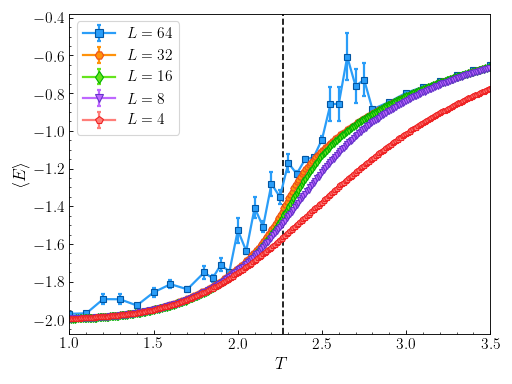

Saving file to: ../plots/energy/energy_all_158.png


In [40]:
energy_temps = np.array([specific_heat64._energy_temps,
                         specific_heat32._energy_temps,
                         specific_heat16._energy_temps,
                         specific_heat8._energy_temps,
                         specific_heat4._energy_temps])
energy_vals = np.array([specific_heat64._avg_energy,
                        specific_heat32._avg_energy,
                        specific_heat16._avg_energy,
                        specific_heat8._avg_energy,
                        specific_heat4._avg_energy])
energy_errors = np.array([specific_heat64._energy_error,
                          specific_heat32._energy_error,
                          specific_heat16._energy_error,
                          specific_heat8._energy_error,
                          specific_heat4._energy_error])
energy_values = {'x': energy_temps, 'y': energy_vals, 'y_err': energy_errors}
energy_fig_labels = np.array([r"$L = 64$", "$L = 32$", r"$L = 16$", 
                              r"$L = 8$", r"$L = 4$"])
energy_xlabel = r"$T$"
energy_ylabel = r"$\langle E \rangle$"
energy_labels = {'fig_labels': energy_fig_labels, 'x_label': energy_xlabel,
                 'y_label': energy_ylabel}
energy_xlim = (1., 3.5)
energy_limits = {'x_lim': energy_xlim}
energy_plot_dir = '../plots/energy/'
energy_plot_num = get_plot_num(energy_plot_dir)
energy_out_file = energy_plot_dir + 'energy_all_{}.png'.format(energy_plot_num)
energy_fig, energy_ax = errorbar_plot(energy_values, energy_labels,
                                      energy_out_file,  energy_limits,  
                                      Tc_line=Tc)

## Specific Heat

<IPython.core.display.Javascript object>


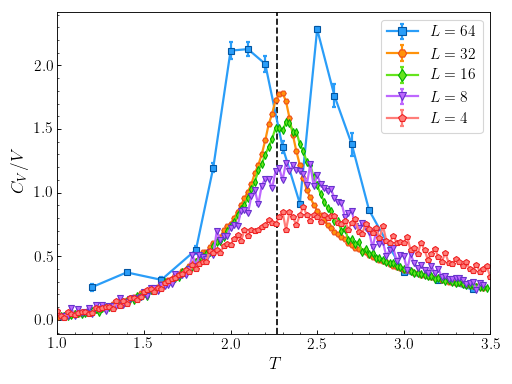

Saving file to: ../plots/specific_heat/specific_heat_all_151.png


In [41]:
Cv_temps = np.array([specific_heat64._spec_heat_temps[::2],
                     specific_heat32._spec_heat_temps[::2],
                     specific_heat16._spec_heat_temps[::2],
                     specific_heat8._spec_heat_temps[::2],
                     specific_heat4._spec_heat_temps[::2]])
Cv_vals = np.array([specific_heat64._spec_heat[::2],
                    specific_heat32._spec_heat[::2],
                    specific_heat16._spec_heat[::2],
                    specific_heat8._spec_heat[::2],
                    specific_heat4._spec_heat[::2]])
Cv_errors = np.array([specific_heat64._spec_heat_err[::2],
                      specific_heat32._spec_heat_err[::2],
                      specific_heat16._spec_heat_err[::2],
                      specific_heat8._spec_heat_err[::2],
                      specific_heat4._spec_heat_err[::2]])
Cv_xlabel = r"$T$"
Cv_ylabel = r"$C_V/V$"
Cv_values = {'x': Cv_temps, 'y': Cv_vals, 'y_err': Cv_errors}
Cv_labels = {'fig_labels': [r"$L = 64$", "$L = 32$", r"$L = 16$", 
                            r"$L = 8$", r"$L = 4$"],
             'x_label': Cv_xlabel, 'y_label': Cv_ylabel}
limits = {'x_lim': (1., 3.5)}
Cv_plot_dir = '../plots/specific_heat/'
Cv_plot_num = get_plot_num(Cv_plot_dir)
Cv_out_file = Cv_plot_dir + 'specific_heat_all_{}.png'.format(Cv_plot_num)
Cv_fig, Cv_ax = errorbar_plot(Cv_values, Cv_labels, Cv_out_file, 
                              limits,  Tc_line=Tc)

## $\mathcal{C}_V \propto \lambda_1$

<IPython.core.display.Javascript object>


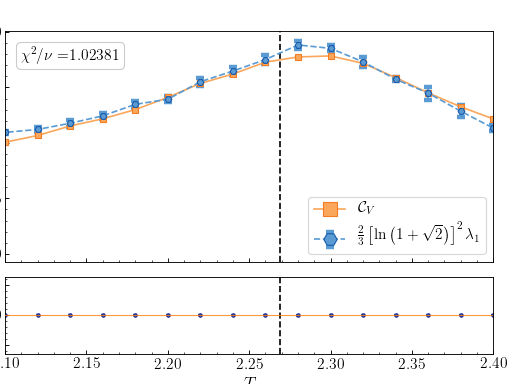

<Container object of 3 artists>

<Container object of 3 artists>

[None, None, None, None]

<Container object of 3 artists>

Text(0.5,25.164,'$T$')

(2.1, 2.4)

(2.1, 2.4)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [33]:
fit_string = (r"$\chi^2/\nu = ${:.5f}".format(red_chisq))
fig, ax = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
Tc = 2./np.log(1+np.sqrt(2))
ax[0].axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax[1].axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax[0].errorbar(sh32_temps, sh32_vals,
               marker='s',
               color=colors[1],
               markeredgecolor=markeredgecolors[1],
               #color='C1',
               #markeredgecolor='#ed4c18',
               markersize=6., 
               #zorder=20,
               ls='-',
               #alpha=0.85,
               elinewidth=2.,
               capsize=2., capthick=2.,
               lw=1.5,
               label=r"$\mathcal{C}_V$")
ax[0].errorbar(pca32_temps_, const*pca32_vals_,
               yerr=const*pca32_err_,
               marker='H', 
               color=colors[0],
               markeredgecolor=markeredgecolors[0],
               #markeredgecolor='#1f1b93',
               markersize=6., 
               #color='C0',
               elinewidth=2.,
               capsize=4., capthick=4.,
               ls='--',
               #zorder=10,
               label=r"$\frac{2}{3}\left[\ln\left(1+\sqrt{2}\right)\right]^2\lambda_1$")
ob = offsetbox.AnchoredText(fit_string, loc=2, pad=0.05, borderpad=1.,
                            prop=dict(size=14))
ob.patch.set(boxstyle='round', edgecolor='#bebebe', facecolor='w',
             alpha=0.8)
ax[0].add_artist(ob)

ax[1].errorbar(sh32_temps, (sh32_vals - const*pca32_vals_),
               yerr=diff_arr_,
               marker='o', 
               markeredgecolor='#1f1b93',
               markersize=3., 
               color='C0',
               elinewidth=2.,
               capsize=2., capthick=2.,
               #alpha=0.7,
               ls='',
               label=(r"$\mathcal{C}_V"
                      + r" - \frac{2}{3}\left[\ln\left("
                      + r" 1+\sqrt{2}\right)\right]^2\lambda_1$"))

ax[1].axhline(y=0, linestyle='-', color='C1', lw=1., zorder=10, alpha=0.8)
fig.tight_layout()
ax[0].legend(loc='lower right', fontsize=14, markerscale=2.)
#ax[1].legend(loc='best', fontsize=10, markerscale=1.6)
#plt.legend(loc='best', fontsize=14, markerscale=1.6)
#ax[0].set_ylabel(r"$C_{V}$", fontsize=16)
#plt.suptitle(r"$C_v$ vs. $T$", fontsize=18, horizontalalignment='center')
plt.subplots_adjust(top=0.92, left=0.01, hspace=0.1)
#ax[0].xlabel(r"$T$", fontsize=16)
ax[1].set_xlabel(r"$T$", fontsize=16)
ax[1].set_xlim(2.1, 2.4)
ax[0].set_xlim(2.1, 2.4)
plt.setp(ax[0].get_xticklabels(), visible=False)
#ax[1].set_title(r"$C_{V}^{simulated} - C_V^{exact}$ vs. $T$", fontsize=18)
#ax[1].set_title(r"Residuals vs. $T$", fontsize=18)
#ax[0].grid()
#ax[1].grid()
#plt.savefig('plots/kauffman_Cv_statistics.png',
#            dpi=400, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


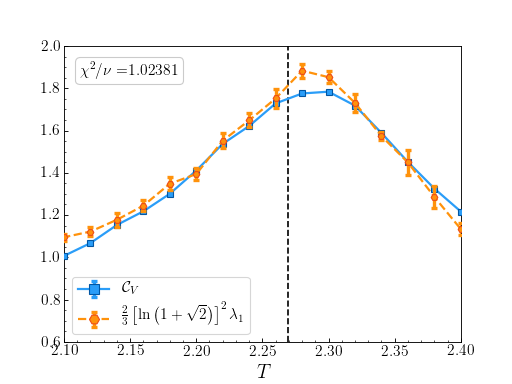

<Container object of 3 artists>

<Container object of 3 artists>

[None, None, None, None]

(2.1, 2.4)

(0.6, 2.0)

Text(0.5,0,'$T$')

Saving file to: ../plots/conjecture/conjecture_compare_18.png


In [60]:
fit_string = (r"$\chi^2/\nu = ${:.5f}".format(red_chisq))
fig, ax = plt.subplots()
ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(specific_heat32._spec_heat_temps[::2], specific_heat32._spec_heat[::2],
            yerr=specific_heat32._spec_heat_err[::2],
            color=colors[0],
            markeredgecolor=markeredgecolors[0],
            marker='s', 
            #color='C0',
            markersize=6, 
            #markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=3., capsize=3., capthick=3.,
            zorder=10,
            alpha=1.0, label=r"$\mathcal{C}_V$")
ax.errorbar(pca32_temps_, const*np.array(pca32_vals_),
            yerr=const*np.array(pca32_err_),
            color=colors[1],
            markeredgecolor=markeredgecolors[1],
            #color='C1', markeredgecolor='#ed4c18', 
            marker='H', 
            fillstyle='full', markersize=6,  lw=2., 
            elinewidth=3., capsize=3., capthick=3.,
            alpha=1., ls='--', zorder=20,
            label=(r"$\frac{2}{3}\left[\ln\left("
                   + r" 1+\sqrt{2}\right)\right]^2\lambda_1$"))

ob = offsetbox.AnchoredText(fit_string, loc=2, pad=0.05, borderpad=1.,
                            prop=dict(size=14))
ob.patch.set(boxstyle='round', edgecolor='#bebebe', facecolor='w',
             alpha=0.8)
ax.add_artist(ob)

#axins = zoomed_inset_axes(ax, 0.3, loc=3)  # zoom = 30%
#axins = inset_axes(ax,
#                   width="40%", # width = 30% of parent_bbox
#                   height="20%", # height : 1 inch
#                   loc=3)
#axins.imshow(Z2, extent=extent, interpolation="nearest",
#             origin="lower")
#axins = plt.axes([2.15, 2.35, 0.75, 2.0])
#axins.errorbar(specific_heat32._spec_heat_temps[::2], 
#               specific_heat32._spec_heat[::2],
#               yerr=specific_heat32._spec_heat_err[::2],
#               marker='s', color='C0',
#               markersize=6,  markeredgecolor='#1f1b93',
#               ls='-', fillstyle='full', lw=2.,
#               elinewidth=3., capsize=3., capthick=3.,
#               zorder=10,
#               alpha=1.0)
#               #label=r"$\mathcal{C}_V$")
#axins.errorbar(pca32_temps_, const*np.array(pca32_vals_),
#               yerr=const*np.array(pca32_err_),
#               color='C1', markeredgecolor='#ed4c18', marker='H', 
#               fillstyle='full', markersize=6,  lw=2., 
#               elinewidth=3., capsize=3., capthick=3.,
#               alpha=1., ls='--', zorder=20)
#               #label=(r"$\frac{2}{3}\left[\ln\left("
#               #       + r" 1+\sqrt{2}\right)\right]^2\lambda_1$"))

# sub region of the original image
#x1, x2, y1, y2 = 2.15, 2.35, 0.75, 2.0
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)
#axins.set_xlabel(fontsize=12)
#axins.set_ylabel(fontsize=12)
# fix the number of ticks on the inset axes
#axins.yaxis.get_major_locator().set_params(nbins=5)
#axins.xaxis.get_major_locator().set_params(nbins=5)
#plt.xticks(visible=False)
#plt.yticks(visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend(loc='lower left', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(2.1, 2.4)
ax.set_ylim(0.6, 2.)
ax.set_xlabel('$T$', fontsize=18)
#ax.set_ylabel('', fontsize=16)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
out_dir = '../plots/conjecture/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'conjecture_compare_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## $\langle N_b\rangle / 2V $

<IPython.core.display.Javascript object>


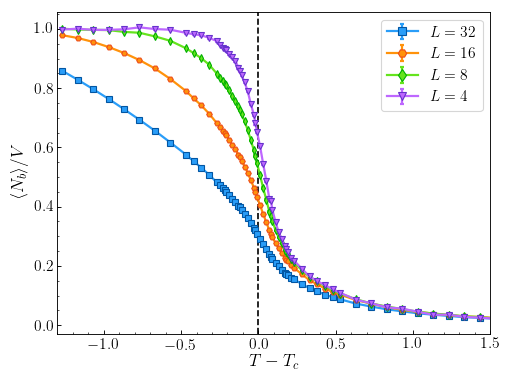

Saving file to: ../plots/bond_counts/Nb_avg_52.png


In [38]:
Nb_temps = np.array([Nb32_temps, Nb16_temps, Nb8_temps, Nb4_temps]) - Tc
Nb_vals = np.array([Nb32[:,0]/(32*32), Nb16[:,0]/(16*16), Nb8[:,0]/(8*8),
                     Nb4[:,0]/(4*4)])
Nb_errs = np.array([Nb32[:,1]/(32*32), Nb16[:,1]/(16*16), Nb8[:,1]/(8*8),
                     Nb4[:,1]/(4*4)])
Nb_xlabel = r"$T - T_c$"
Nb_ylabel = r"$\langle N_b\rangle / V$"
Nb_values = {'x': Nb_temps, 'y': Nb_vals, 'y_err': Nb_errs}
Nb_labels = {'fig_labels': [r"$L = 32$", r"$L = 16$", r"$L = 8$", r"$L = 4$"],
             'x_label': Nb_xlabel, 'y_label': Nb_ylabel}
limits = {'x_lim': (-1.3, 1.5)}
Nb_plot_dir = '../plots/bond_counts/'
Nb_plot_num = get_plot_num(Nb_plot_dir)
Nb_out_file = Nb_plot_dir + 'Nb_avg_{}.png'.format(Nb_plot_num)
Nb_fig, Nb_ax = errorbar_plot(Nb_values, Nb_labels, Nb_out_file, 
                              limits,  Tc_line=0)


## $\langle \Delta_{N_b}^2\rangle$ Plots

### $\langle \Delta_{N_b}^2\rangle$

<IPython.core.display.Javascript object>


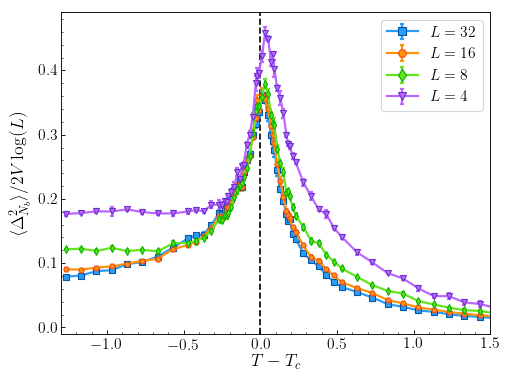

Saving file to: ../plots/bond_stats/delta_Nb_all_53.png


In [50]:
#delta_Nb_temps = np.array([Nb64_temps, 
delta_Nb_temps = np.array([Nb32_temps, 
                           Nb16_temps, 
                           Nb8_temps,
                           Nb4_temps]) - Tc
#delta_Nb_scale_arr = np.array([2*64*64*np.log(64),
delta_Nb_scale_arr = np.array([2*32*32*np.log(32),
                               2*16*16*np.log(16),
                               2*8*8*np.log(8),
                               2*4*4*np.log(4)])
#delta_Nb_vals = np.array([delta_Nb64[:,0], 
delta_Nb_vals = np.array([delta_Nb32[:,0] / delta_Nb_scale_arr[0], 
                          delta_Nb16[:,0] / delta_Nb_scale_arr[1],
                          delta_Nb8[:,0] / delta_Nb_scale_arr[2], 
                          delta_Nb4[:,0] / delta_Nb_scale_arr[3]])
#delta_Nb_err = np.array([delta_Nb64[:,1], 
delta_Nb_err = np.array([delta_Nb32[:,1] / delta_Nb_scale_arr[0], 
                         delta_Nb16[:,1] / delta_Nb_scale_arr[1],
                         delta_Nb8[:,1] / delta_Nb_scale_arr[2], 
                         delta_Nb4[:,1] / delta_Nb_scale_arr[3]])
delta_Nb_values = {'x': delta_Nb_temps, 'y': delta_Nb_vals, 
                   'y_err': delta_Nb_err}
delta_Nb_xlabel = r"$T - T_c$"
delta_Nb_ylabel = r"$\langle \Delta_{N_b}^2\rangle / 2V \log(L)$"
#delta_Nb_labels = {'fig_labels': [r"$L = 64", 
delta_Nb_labels = {'fig_labels': [r"$L = 32", 
                                  r"$L = 16$", 
                                  r"$L = 8$",
                                  r"$L = 4$"],
                   'x_label': delta_Nb_xlabel, 'y_label': delta_Nb_ylabel}
delta_Nb_limits = {'x_lim': (-1.3, 1.5)}
delta_Nb_plot_dir = '../plots/bond_stats/'
delta_Nb_plot_num = get_plot_num(Nb_plot_dir)
delta_Nb_out_file = (delta_Nb_plot_dir 
                     + 'delta_Nb_all_{}.png'.format(delta_Nb_plot_num))
delta_Nb_fig, delta_Nb_ax = errorbar_plot(delta_Nb_values, 
                                          delta_Nb_labels, delta_Nb_out_file, 
                                          delta_Nb_limits,  Tc_line=0)

In [ ]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(32*(Nb32_temps-Tc), delta_Nb32[:,0]/(2*32*32*np.log(32)), 
            yerr=delta_Nb32[:,1]/(2*32*32*np.log(32)),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2., capsize=2, capthick=2,
            label='L=32')
ax.errorbar(16*(Nb16_temps-Tc), delta_Nb16[:,0]/(2*16*16*np.log(16)), 
            yerr=delta_Nb16[:,1]/(2*16*16*np.log(16)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar(8*(Nb8_temps-Tc), delta_Nb8[:,0]/(2*8*8*np.log(8)),
            yerr=delta_Nb8[:,1]/(2*8*8*np.log(8)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
#ax.errorbar(4*(Nb4_temps-Tc), delta_Nb4[:,0]/(2*4*4*np.log(4)), 
#            yerr=delta_Nb4[:,1]/(2*4*4*np.log(4)),
#            color='C1', markeredgecolor='#ed4c18', marker='v', 
#            fillstyle='full', markersize=5,  lw=2, 
#            alpha=1., ls='-',
#            elinewidth=2.,  capsize=2, capthick=2,
#            label='L=4')
ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-20,20)
ax.set_xlabel('$(T-T_c)L$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle/\log(L)$", fontsize=16)
out_dir = '../plots/bond_stats/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Rescaled:  $\langle \Delta_{N_b}^2\rangle / L^{1/4}$ vs.  $(T-Tc)L^{1/4}$

In [ ]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32_temps-Tc)*32**(0.2029), delta_Nb32[:,0]/(32*32*32**(0.3862)), 
            yerr=delta_Nb32[:,1]/(32*32*32**(1./4)),
            marker='s', color='C0', alpha=1.,
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16_temps-Tc)*16**(0.2029), delta_Nb16[:,0]/(16*16*16**(0.3862)), 
            yerr=delta_Nb16[:,1]/(16*16*16**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8_temps-Tc)*8**(0.2029), delta_Nb8[:,0]/(8*8*8**(0.3862)), 
            yerr=delta_Nb8[:,1]/(8*8*8**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4_temps-Tc)*4**(0.2029), delta_Nb4[:,0]/(4*4*4**(0.3862)), 
            yerr=delta_Nb4[:,1]/(4*4*4**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=4,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(-0.6, 0.6)
#ax.grid(True)
ax.set_xlabel('$(T - T_c)L^{0.2029}$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle / L^{0.3862}$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
out_dir = '../plots/bond_stats/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_rescaled_zoomed_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### $\langle \Delta_{N_b}^2\rangle$ (blocked)

In [ ]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(Nb32b_temps, delta_Nb32b[:,0]/(2*16*16), 
            yerr=delta_Nb32b[:,1]/(2*16*16),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=16$")
ax.errorbar(Nb16b_temps, delta_Nb16b[:,0]/(2*8*8),
            yerr=delta_Nb16b[:,1]/(2*8*8),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=8$")
ax.errorbar(Nb8b_temps, delta_Nb8b[:,0]/(2*4*4), 
            yerr=delta_Nb8b[:,1]/(2*4*4),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=4$")
ax.errorbar(Nb4b_temps, delta_Nb4b[:,0]/(2*2*2), 
            yerr=delta_Nb4b[:,1]/(2*2*2),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=2$")

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$, blocked", fontsize=16)
out_dir = '../plots/bond_stats/blocked/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Rescaled (blocked):  $\langle \Delta_{N_b}^2\rangle / L^{1/4}$ vs.  $(T-Tc)L^{1/4}$

In [ ]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32b_temps-Tc)*16**(.2029),
            delta_Nb32b[:,0]/(2*16*16*16**(0.3862)), 
            yerr=delta_Nb32b[:,1]/(2*16*16*16**(1./4)),
            marker='s', color='C0', alpha=1.,
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16b_temps-Tc)*8**(.2029), 
            delta_Nb16b[:,0]/(2*8*8*8**(0.3862)), 
            yerr=delta_Nb16b[:,1]/(2*8*8*8**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8b_temps-Tc)*4**(.2029), 
            delta_Nb8b[:,0]/(2*4*4*4**(0.3862)), 
            yerr=delta_Nb8b[:,1]/(2*4*4*4**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4b_temps-Tc)*2**(.2029), 
            delta_Nb4b[:,0]/(2*2*2*2**(0.3862)), 
            yerr=delta_Nb4b[:,1]/(2*2*2*2**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=4,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-3., 2.5)
ax.set_xlabel('$(T - T_c) L^{.2029}$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle/L^{0.3862}$, blocked", 
              fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
out_dir = '../plots/bond_stats/blocked/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_rescaled_{}.png'.format(new_num)
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## PCA  $(\lambda_1)$ Plots

### $\lambda_1$

In [51]:
pca_temps = np.array([pca32_temps_, pca16_temps_, pca8_temps_, pca4_temps_])
pca_vals = np.array([pca32_vals_, pca16_vals_, pca8_vals_, pca4_vals_])
pca_err = np.array([pca32_err_, pca16_err_, pca8_err_, pca4_err_])
pca_values = {'x': pca_temps, 'y': pca_vals, 'y_err': pca_err}
pca_xlabel = r"$T$"
pca_ylabel = r"$\lambda_1$"
pca_labels = {'fig_labels': [r"$L = 32$", r"$L = 16$", r"$L = 8$", r"$L = 4$"],
             'x_label': pca_xlabel, 'y_label': pca_ylabel}
limits = {'x_lim': (1., 3.5)}
pca_plot_dir = '../plots/pca/'
pca_plot_num = get_plot_num(pca_plot_dir)
pca_out_file = pca_plot_dir + 'leading_eigenvalue_all_{}.png'.format(pca_plot_num)
pca_fig, pca_ax = errorbar_plot(pca_values, pca_labels, pca_out_file, 
                                limits,  Tc_line=Tc)

NameError: name 'pca32_temps_' is not defined

<IPython.core.display.Javascript object>


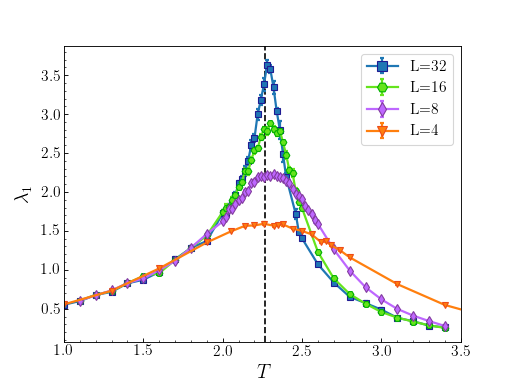

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(1.0, 3.5)

Text(0.5,0,'$T$')

Text(0,0.5,'$\\lambda_1$')

Saving file to: ../plots/pca/leading_eigenvalue_all_72.png


In [55]:
fig, ax = plt.subplots()
ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(pca32_temps_, pca32_vals_,
            yerr=pca32_err_,
            marker='s', color='C0',
            markersize=6,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label='L=32')
ax.errorbar(pca16_temps_, pca16_vals_,
            yerr=pca16_err_,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=6., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')
ax.errorbar(pca8_temps_, pca8_vals_,
            yerr=pca8_err_,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=6, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label='L=8')
ax.errorbar(pca4_temps_, pca4_vals_,
            yerr=pca4_err_,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=6,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1.,3.5)
ax.set_xlabel('$T$', fontsize=18)
ax.set_ylabel('$\lambda_1$', fontsize=18)
out_dir = '../plots/pca/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### $\lambda_1$ (rescaled)

In [ ]:
fig, ax = plt.subplots()
ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((pca32_temps-Tc)*32, pca32_vals/np.log(32),
            yerr=pca32_err/np.log(32),
            marker='s', color='C0',
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label='L=32')
ax.errorbar((pca16_temps-Tc)*16, pca16_vals/np.log(16),
            yerr=pca16_err/np.log(16),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')
ax.errorbar((pca8_temps-Tc)*8, pca8_vals/np.log(8),
            yerr=pca8_err/np.log(8),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label='L=8')
#ax.errorbar((pca4_temps-Tc)*4, pca4_vals/np.log(4),
#            yerr=pca4_err/np.log(4),
#            color='C1', markeredgecolor='#ed4c18', marker='v', 
#            fillstyle='full', markersize=4,  lw=2., elinewidth=2., 
#            alpha=1., capsize=2, capthick=2,  ls='-',
#            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(-5,5)
ax.set_xlabel('$(T-T_c)L$', fontsize=16)
ax.set_ylabel('$\lambda_1/log(L)$', fontsize=16)
out_dir = '../plots/pca/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
pca32_temps = np.array(pca32_temps)
pca32_vals = np.array(pca32_vals)
pca32_err = np.array(pca32_err)
pca16_temps = np.array(pca16_temps)
pca16_vals = np.array(pca16_vals)
pca16_err = np.array(pca16_err)
pca8_temps = np.array(pca8_temps)
pca8_vals = np.array(pca8_vals)
pca8_err = np.array(pca8_err)
pca4_temps = np.array(pca4_temps)
pca4_vals = np.array(pca4_vals)
pca4_err = np.array(pca4_err)

fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((pca32_temps-Tc)*32**(1./4), pca32_vals/(32**(1./4)),
            yerr=pca32_err/(32**(1./4)),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label=r"$L^{\prime}=16$")
ax.errorbar((pca16_temps - Tc)*16**(1./4), pca16_vals/(16**(1./4)),
            yerr=pca16_err/(16**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label=r"$L^{\prime}=8$")
ax.errorbar((pca8_temps - Tc)*8**(1./4), pca8_vals/(8**(1./4)),
            yerr=pca8_err/(8**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label=r"$L^{\prime}=4$")
ax.errorbar((pca4_temps - Tc)*4**(1./4), pca4_vals/(4**(1./4)),
            yerr=pca4_err/(4**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label=r"$L^{\prime}=2$")

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(1., 3.5)
ax.set_xlabel('$(T - T_c)L^{1/4}$', fontsize=16)
ax.set_ylabel('$\lambda_1 / L^{1/4}$', fontsize=16)
out_dir = '../plots/pca/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = int(max(existing))
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_rs_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()
plt.show()

### $\lambda_1^{blocked}$

In [ ]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32b_temps, pca32b_vals,
            yerr=pca32b_err,
            marker='s', color='C0',
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label=r"$L^{\prime}=16$")
ax.errorbar(pca16b_temps, pca16b_vals,
            yerr=pca16b_err,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label=r"$L^{\prime}=8$")
ax.errorbar(pca8b_temps, pca8b_vals,
            yerr=pca8b_err,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label=r"$L^{\prime}=4$")
ax.errorbar(pca4b_temps, pca4b_vals,
            yerr=pca4b_err,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=4,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label=r"$L^{\prime}=2$")
ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_1^{blocked}$', fontsize=16)
out_dir = '../plots/pca/blocked/double_bonds_0/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()
plt.show()

### $\lambda_1^{blocked}$ (rescaled)

In [ ]:
pca32b_temps = np.array(pca32b_temps)
pca32b_vals = np.array(pca32b_vals)
pca32b_err = np.array(pca32b_err)
pca16b_temps = np.array(pca16b_temps)
pca16b_vals = np.array(pca16b_vals)
pca16b_err = np.array(pca16b_err)
pca8b_temps = np.array(pca8b_temps)
pca8b_vals = np.array(pca8b_vals)
pca8b_err = np.array(pca8b_err)
pca4b_temps = np.array(pca4b_temps)
pca4b_vals = np.array(pca4b_vals)
pca4b_err = np.array(pca4b_err)

fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((pca32b_temps-Tc)*16**(1./4), pca32b_vals/(2*16**(1./4)),
            yerr=pca32b_err/(2*16**(1./4)),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label=r"$L^{\prime}=16$")
ax.errorbar((pca16b_temps - Tc)*8**(1./4), pca16b_vals/(2*8**(1./4)),
            yerr=pca16b_err/(2*8**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label=r"$L^{\prime}=8$")
ax.errorbar((pca8b_temps - Tc)*4**(1./4), pca8b_vals/(2*4**(1./4)),
            yerr=pca8b_err/(2*4**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label=r"$L^{\prime}=4$")
ax.errorbar((pca4b_temps - Tc)*2**(1./4), pca4b_vals/(2*2**(1./4)),
            yerr=pca4b_err/(2*2**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label=r"$L^{\prime}=2$")

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(1., 3.5)
ax.set_xlabel('$(T - T_c)L^{1/4}$', fontsize=16)
ax.set_ylabel('$\lambda_1^{blocked} / L^{1/4}$', fontsize=16)
out_dir = '../plots/pca/blocked/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_rs_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()
plt.show()

## Peak Analysis

### FWHM

In [ ]:
from scipy.interpolate import UnivariateSpline
def fwhm1(x, y):
    # create a spline of x and blue-np.max(blue)/2 
    spline = UnivariateSpline(x, y-np.max(y)/2, s=0)
    roots = spline.roots()
    r1 = roots[0]
    r2 = roots[-1]
    #r1, r2 = spline.roots() # find the roots
    return np.abs(r1 - r2)

In [ ]:
fwhm32 = fwhm1((Nb32_temps-Tc)*32, delta_Nb32[:,0]/(2*32*32*np.log(32)))
fwhm16 = fwhm1((Nb16_temps-Tc)*16, delta_Nb16[:,0]/(2*16*16*np.log(16)))
fwhm8 = fwhm1((Nb8_temps-Tc)*8, delta_Nb8[:,0]/(2*8*8*np.log(8)))
#fwhm4 = fwhm1((Nb4_temps-Tc)*4, delta_Nb4[:,0]/(2*4*4*np.log(4)))

In [ ]:
fwhm32, fwhm16, fwhm8, fwhm4

In [ ]:
#x_fwhm = np.linspace(8, 32, 500)
L_fwhm = np.array([8, 16, 32])
fwhm_arr = np.array([fwhm8, fwhm16, fwhm32])
m_fwhm, b_fwhm = np.polyfit(L_fwhm, fwhm_arr, 1)
x_fwhm = np.linspace(8, 32, 500)
fwhm_fit = b_fwhm + x_fwhm * m_fwhm

In [ ]:
m_fwhm, b_fwhm

In [ ]:
fig, ax = plt.subplots()
ax.plot(32, fwhm32,
          marker='s', 
          markeredgecolor='#1f1b93',
          markersize=8., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.plot(16, fwhm16,
          marker='H', 
          color='#ABE479', 
          markeredgecolor='#00B000',
          markersize=8, 
          ls='',
          label=r"$L = 16$")
ax.plot(8, fwhm8,
          marker='d',
          markersize=8, 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          ls='', 
          label=r"$L = 8$")
#ax.plot(4, fwhm4,
#          marker='d', 
#          #markersize=5, 
#          color='C1',
#          markeredgecolor='#ed4c18',
#          ls='',
#          label=r"$L=4$")
ax.plot(x_fwhm, fwhm_fit,
        ls='-',
        color='k',
        label=r"${:.5g} + {:.3g}L$".format(b_fwhm, m_fwhm))
        #label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b0), m0))
#ax.legend()
#ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
ylabel = (r"FWHM of $\langle \Delta_{N_b}^2 \rangle / \log(L)$" + " vs. "
          + r"$(T-T_c)L$")

 
plt.ylabel(ylabel, 
           fontsize=16)
plt.xlabel(r"$L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/FWHM/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'fwhm_fit_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Peak value 

In [ ]:
delta_Nb32_peak = np.max(delta_Nb32[:,0]/(2*32*32))
delta_Nb32b_peak = np.max(delta_Nb32b[:,0]/(2*16*16))
delta_Nb16_peak = np.max(delta_Nb16[:,0]/(2*16*16))
delta_Nb16b_peak = np.max(delta_Nb16b[:,0]/(2*8*8))
delta_Nb8_peak = np.max(delta_Nb8[:,0]/(2*8*8))
delta_Nb8b_peak = np.max(delta_Nb8b[:,0]/(2*4*4))
delta_Nb4_peak = np.max(delta_Nb4[:,0]/(2*4*4))
delta_Nb4b_peak = np.max(delta_Nb4b[:,0]/(2*2*2))

In [ ]:
L_arr = np.log(np.array([4, 8, 16, 32]))
inv_L_arr = np.log(np.array([1./32, 1./16, 1./8, 1./4]))
#log_L_arr = np
delta_Nb_peak_arr = np.array([
    delta_Nb4_peak, delta_Nb8_peak, delta_Nb16_peak, delta_Nb32_peak
])
m0, b0 = np.polyfit(L_arr, delta_Nb_peak_arr, 1)

In [ ]:
fwhm_fit

In [ ]:
#fit_x0 = np.linspace(1./32, 1./4, 500)
fit_x0 = np.linspace(4, 32, 500)
#fit_x = np.arange(2, 32)
log_y0_fit = b0 + np.log(fit_x0) * m0
fit_y0 = np.exp(log_y0_fit)

In [ ]:
fig, ax = plt.subplots()
ax.semilogx(32, delta_Nb32_peak,
          marker='s', 
          markeredgecolor='#1f1b93',
          #markersize=5., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.semilogx(16, delta_Nb16_peak,
          marker='H', 
          color='C1',
          markeredgecolor='#ed4c18',
          #markersize=5, 
          ls='',
          label=r"$L = 16$")
ax.semilogx(8, delta_Nb8_peak,
          marker='v',
          #markersize=5, 
          color='#ABE479', 
          markeredgecolor='#00B000',
          ls='', 
          label=r"$L = 8$")
ax.semilogx(4, delta_Nb4_peak,
          marker='d', 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          #markersize=5, 
          ls='',
          label=r"$L=4$")
ax.plot(fit_x0, log_y0_fit,
        ls='-',
        color='k',
        label=r"${:.3g}L + {:.5g}$".format(m0, b0))
        #label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b0), m0))
#ax.legend()
#ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
plt.ylabel(r"$\max\{\langle \Delta_{N_b}^2\rangle\}$", 
           fontsize=16)
plt.xlabel(r"$L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/delta_Nb/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'delta_Nb_peak_val_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Peak location

In [ ]:
delta_Nb32_peakT = Nb32_temps[np.argmax(delta_Nb32)] - Tc
#delta_Nb32b_peakT = Nb32b_temps[np.argmax(delta_Nb32b)]
delta_Nb16_peakT = Nb16_temps[np.argmax(delta_Nb16)] - Tc
#delta_Nb16b_peakT = Nb16b_temps[np.argmax(delta_Nb16b)]
delta_Nb8_peakT = Nb8_temps[np.argmax(delta_Nb8)] - Tc
#delta_Nb8b_peakT = Nb8b_temps[np.argmax(delta_Nb8b)]
delta_Nb4_peakT = Nb4_temps[np.argmax(delta_Nb4)] - Tc
#delta_Nb4b_peakT = Nb4b_temps[np.argmax(delta_Nb4b)]

In [ ]:
delta_Nb_peakT_arr = np.log(np.array([
    delta_Nb4_peakT, delta_Nb8_peakT, delta_Nb16_peakT, delta_Nb32_peakT
]))
m1, b1 = np.polyfit(L_arr, delta_Nb_peakT_arr, 1)

In [ ]:
fit_x1 = np.linspace(4, 32, 500)
#fit_x = np.arange(2, 32)
log_y1_fit = b1 + np.log(fit_x1) * m1
fit_y1 = np.exp(log_y1_fit)

In [ ]:
fig, ax = plt.subplots()
ax.loglog(32, delta_Nb32_peakT,
          marker='s', 
          markeredgecolor='#1f1b93',
          #markersize=5., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.loglog(16, delta_Nb16_peakT,
          marker='H', 
          color='C1',
          markeredgecolor='#ed4c18',
          #markersize=5, 
          ls='',
          label=r"$L = 16$")
ax.loglog(8, delta_Nb8_peakT,
          marker='v',
          #markersize=5, 
          color='#ABE479', 
          markeredgecolor='#00B000',
          ls='', 
          label=r"$L = 8$")
ax.loglog(4, delta_Nb4_peakT,
          marker='d', 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          #markersize=5, 
          ls='',
          label=r"$L=4$")
ax.plot(fit_x1, fit_y1,
        ls='-',
        color='k',
        #label=r"${:.3g}L + {:.5g}$".format(m, b))
        label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b1), m1))
#ax.legend()
#ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
plt.ylabel(r"$(T^{*} - T_c)$", fontsize=16)
plt.xlabel(r"$L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/delta_NbT/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'delta_Nb_peak_pos_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.loglog(32, delta_Nb32_peakT,
          marker='s', 
          markeredgecolor='#1f1b93',
          #markersize=5., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.loglog(16, delta_Nb16_peakT,
          marker='H', 
          color='C1',
          markeredgecolor='#ed4c18',
          #markersize=5, 
          ls='',
          label=r"$L = 16$")
ax.loglog(8, delta_Nb8_peakT,
          marker='v',
          #markersize=5, 
          color='#ABE479', 
          markeredgecolor='#00B000',
          ls='', 
          label=r"$L = 8$")
ax.loglog(4, delta_Nb4_peakT,
          marker='d', 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          #markersize=5, 
          ls='',
          label=r"$L=4$")
ax.plot(fit_x1, fit_y1,
        ls='-',
        color='k',
        #label=r"${:.3g}L + {:.5g}$".format(m, b))
        label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b1), m1))
#ax.legend()
#ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
plt.ylabel(r"$(T^{*} - T_c)$", fontsize=16)
plt.xlabel(r"$L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/delta_NbT/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
#out_file = out_dir + 'delta_Nb_peak_pos_{}.png'.format(new_num)
#print("Saving file to: {}".format(out_file))
#plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## Plot $\langle N_{sites^{(2)}} \rangle / \langle N_b\rangle$

In [65]:
sites2_temps_ = []
sites2_ratio = []
sites2_err = []
for key, val in sites2_dict.items():
    try:
        Nb = Nb32_dict[key][0] / (2*32*32)
        Nb_err = Nb32_dict[key][1] / (2*32*32)
        sites2_temps_.append(float(key))
        sites2_ratio.append(val / Nb)
        sites2_err.append(Nb_err)
    except KeyError:
        continue

<IPython.core.display.Javascript object>


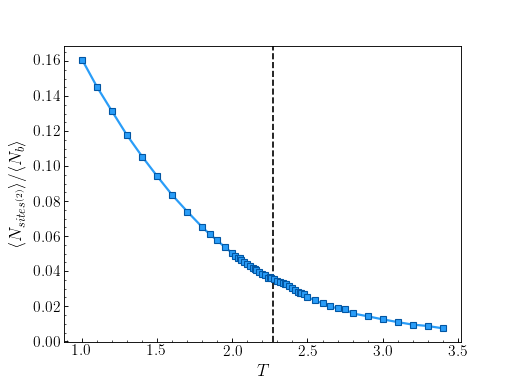

<Container object of 3 artists>

Text(0.5,0,'$T$')

Text(0,0.5,'$\\langle N_{sites^{(2)}}\\rangle / \\langle N_b\\rangle$')

Saving file to: ../plots/twice_visited_sites/twice_visited_sites_ratio_32.png


In [67]:
fig, ax = plt.subplots()
ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(sites2_temps_, np.array(sites2_ratio) / (32*32),
            yerr=np.array(sites2_err)/(32*32),
            marker='s', color=colors[0],
            markersize=6,  
            markeredgecolor=markeredgecolors[0],
           # markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2)
            #label='L=32')
ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(1., 3.5)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle N_{sites^{(2)}}\rangle / \langle N_b\rangle$",
              fontsize=16)
out_dir = '../plots/twice_visited_sites/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = int(max(existing))
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'twice_visited_sites_ratio_32.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()